## **Q1**

In [9]:
import tensorflow as tf  # now import the tensorflow module
print(tf.__version__)
from tensorflow import keras

# you would also need numpy for tensorflow programming. Use pip install numpy
import numpy as np 
from matplotlib import pyplot as plt

2.18.0


In [3]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer

from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import Imputer, StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *

## **Q1.1**

In [6]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer):
    def __init__(self):
        super().__init__()
        self.unaccounted_labels = []

    def _transform(self, dataset):
        def label_to_multiclass(name):
            if name == 'normal':
                return 0.0
            elif name in ['apache2', 'back', 'land', 'neptune',
                          'mailbomb', 'pod', 'processtable',
                          'smurf', 'teardrop', 'udpstorm', 'worm']:
                return 1.0
            elif name in ['ftp_write', 'guess_passwd', 'httptunnel', 
                          'imap', 'multihop', 'named', 'phf', 'sendmail', 
                          'Snmpgetattack', 'spy', 'snmpguess', 'warezclient', 
                          'warezmaster', 'xlock', 'xsnoop']:
                return 2.0
            elif name in ['buffer_overflow', 'loadmodule', 'perl', 'ps', 
                          'rootkit', 'sqlattack', 'xterm']:
                return 3.0
            elif name in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']:
                return 4.0
            else:
                if name not in self.unaccounted_labels:
                    self.unaccounted_labels.append(name)
                return None 

        label_to_multiclass_udf = udf(label_to_multiclass, DoubleType())
        output_df = dataset.withColumn('outcome', label_to_multiclass_udf(col('class'))).drop("class")
        output_df = output_df.na.drop(subset=["outcome"])
        output_df = output_df.drop('difficulty')

        if self.unaccounted_labels:
            print("Unaccounted labels:", self.unaccounted_labels)

        return output_df

class FeatureTypeCaster(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df

class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop=None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    stage_typecaster = FeatureTypeCaster()
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)
    
    feature_cols = continuous_cols + binary_cols + nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                                "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
    stage_outcome = OutcomeCreater()
    stage_column_dropper = ColumnDropper(columns_to_drop=nominal_cols + nominal_id_cols + nominal_onehot_cols + binary_cols + continuous_cols + ['vectorized_features'])

    pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, stage_nominal_onehot_encoder,
                                stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper])
    return pipeline

In [ ]:
appName = "TensorFlow HW"
master = "local"
# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50967)
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "C:\spark\spark-3.5.2-bin-hadoop3\python\p

In [2]:
file_path_train = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw7-tensorflow-and-kafka-nick1117\NSL-KDD\KDDTrain+.txt"
file_path_test = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw7-tensorflow-and-kafka-nick1117\NSL-KDD\KDDTest+.txt"


In [7]:
nslkdd_raw = spark.read.csv(file_path_train,header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv(file_path_test,header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)

In [8]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

nslkdd_df_train = nslkdd_df 
nslkdd_df_validate,nslkdd_df_test = nslkdd_df_test.randomSplit([0.5,0.5])

nslkdd_df_train_pandas = nslkdd_df_train.withColumn('features', to_array('features')).toPandas()
nslkdd_df_validate_pandas = nslkdd_df_validate.withColumn('features', to_array('features')).toPandas()
nslkdd_df_test_pandas = nslkdd_df_test.withColumn('features', to_array('features')).toPandas()

In [ ]:
x_train = tf.constant(np.array(nslkdd_df_train_pandas['features'].values.tolist()))
y_train = tf.constant(np.array(nslkdd_df_train_pandas['outcome'].values.tolist()))

x_validate = tf.constant(np.array(nslkdd_df_validate_pandas['features'].values.tolist()))
y_validate = tf.constant(np.array(nslkdd_df_validate_pandas['outcome'].values.tolist()))


x_test = tf.constant(np.array(nslkdd_df_test_pandas['features'].values.tolist()))
y_test = tf.constant(np.array(nslkdd_df_test_pandas['outcome'].values.tolist()))

In [14]:
print(f"Training Data Shape: {x_train.shape}, {y_train.shape}")
print(f"Validation Data Shape: {x_validate.shape}, {y_validate.shape}")
print(f"Test Data Shape: {x_test.shape}, {y_test.shape}")

Training Data Shape: (125973, 113), (125973,)
Validation Data Shape: (11107, 113), (11107,)
Test Data Shape: (11259, 113), (11259,)


## **Q1.2**

In [32]:
model = keras.Sequential( [keras.layers.Dense(64,activation='relu'),
                          keras.layers.Dense(32, activation='relu'),
                          keras.layers.Dense(16, activation='relu'),
                          keras.layers.Dense(5, activation='softmax')])


model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.02),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='Accuracy')])

model.fit(x_train, y_train, epochs = 30,batch_size = 64, validation_data=(x_validate,y_validate),verbose = 2)

Epoch 1/30
1969/1969 - 1s - 721us/step - Accuracy: 0.9624 - loss: 0.1367 - val_Accuracy: 0.7519 - val_loss: 1.6480
Epoch 2/30
1969/1969 - 1s - 505us/step - Accuracy: 0.9849 - loss: 0.0472 - val_Accuracy: 0.7730 - val_loss: 1.7418
Epoch 3/30
1969/1969 - 1s - 563us/step - Accuracy: 0.9883 - loss: 0.0363 - val_Accuracy: 0.7780 - val_loss: 1.8543
Epoch 4/30
1969/1969 - 1s - 527us/step - Accuracy: 0.9898 - loss: 0.0312 - val_Accuracy: 0.7669 - val_loss: 2.1788
Epoch 5/30
1969/1969 - 1s - 531us/step - Accuracy: 0.9912 - loss: 0.0281 - val_Accuracy: 0.7702 - val_loss: 2.0930
Epoch 6/30
1969/1969 - 1s - 529us/step - Accuracy: 0.9918 - loss: 0.0262 - val_Accuracy: 0.7699 - val_loss: 2.2588
Epoch 7/30
1969/1969 - 1s - 506us/step - Accuracy: 0.9924 - loss: 0.0252 - val_Accuracy: 0.7718 - val_loss: 2.1767
Epoch 8/30
1969/1969 - 1s - 514us/step - Accuracy: 0.9925 - loss: 0.0240 - val_Accuracy: 0.7697 - val_loss: 2.3066
Epoch 9/30
1969/1969 - 1s - 499us/step - Accuracy: 0.9929 - loss: 0.0226 - val_A

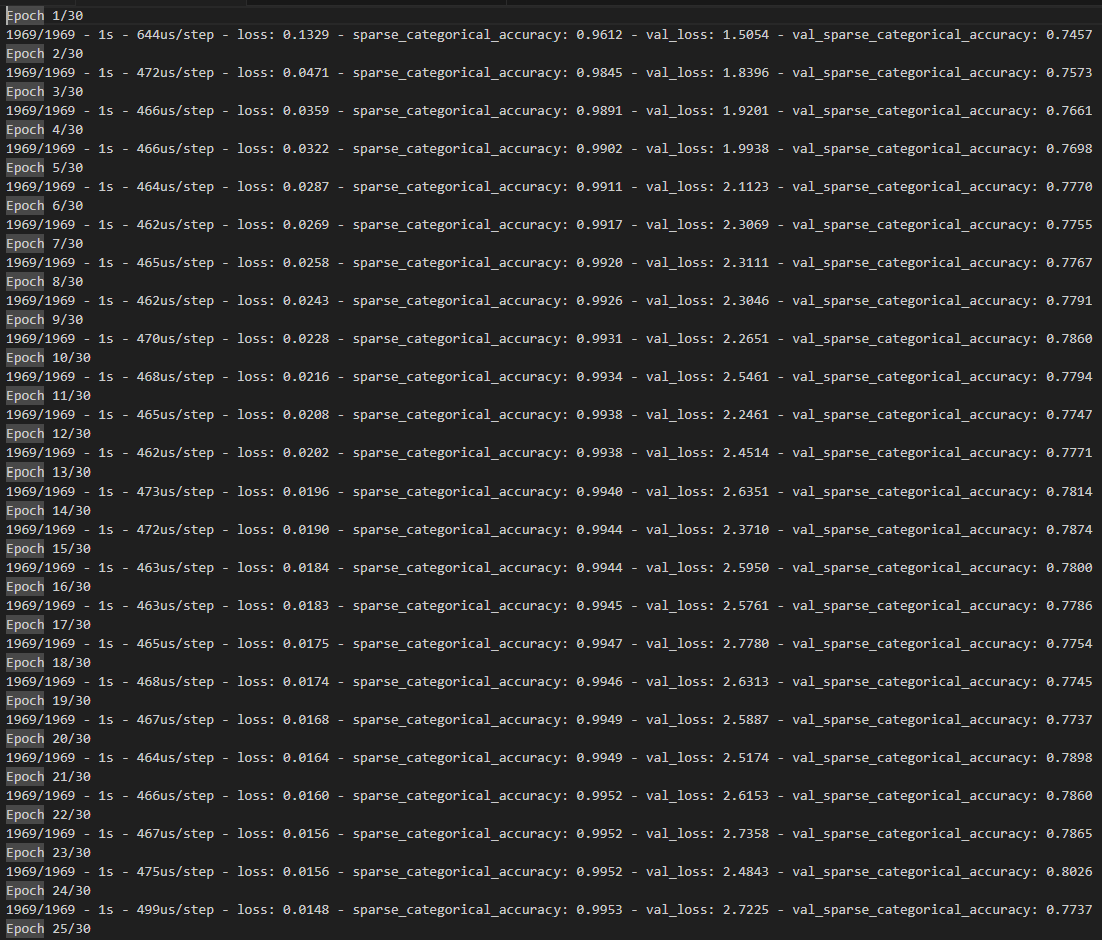

In [22]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

352/352 - 0s - 425us/step - loss: 2.3773 - sparse_categorical_accuracy: 0.7955
Test Loss: 2.3772711753845215, Test Accuracy: 0.7954525351524353


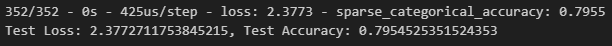

## **Q1.3**

In [36]:
import datetime

log_dir = "logs14763/myfirstlog/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x=x_train, y=y_train, 
          epochs=20, verbose = 2, batch_size=64,
          validation_data=(x_validate, y_validate), 
          callbacks=[tensorboard_callback])

Epoch 1/20
1969/1969 - 1s - 688us/step - Accuracy: 0.9966 - loss: 0.0109 - val_Accuracy: 0.7783 - val_loss: 3.3038
Epoch 2/20
1969/1969 - 1s - 718us/step - Accuracy: 0.9965 - loss: 0.0107 - val_Accuracy: 0.7779 - val_loss: 3.3191
Epoch 3/20
1969/1969 - 1s - 644us/step - Accuracy: 0.9966 - loss: 0.0109 - val_Accuracy: 0.7742 - val_loss: 3.4553
Epoch 4/20
1969/1969 - 1s - 659us/step - Accuracy: 0.9966 - loss: 0.0107 - val_Accuracy: 0.7749 - val_loss: 3.3345
Epoch 5/20
1969/1969 - 1s - 700us/step - Accuracy: 0.9966 - loss: 0.0108 - val_Accuracy: 0.7732 - val_loss: 3.3329
Epoch 6/20
1969/1969 - 1s - 646us/step - Accuracy: 0.9968 - loss: 0.0105 - val_Accuracy: 0.7743 - val_loss: 3.3384
Epoch 7/20
1969/1969 - 1s - 633us/step - Accuracy: 0.9966 - loss: 0.0104 - val_Accuracy: 0.7730 - val_loss: 3.4444
Epoch 8/20
1969/1969 - 1s - 732us/step - Accuracy: 0.9967 - loss: 0.0105 - val_Accuracy: 0.7734 - val_loss: 3.4864
Epoch 9/20
1969/1969 - 1s - 666us/step - Accuracy: 0.9968 - loss: 0.0102 - val_A

In [34]:
%reload_ext tensorboard

In [35]:
%tensorboard --logdir logs14763/myfirstlog/

Reusing TensorBoard on port 6007 (pid 28668), started 0:17:40 ago. (Use '!kill 28668' to kill it.)

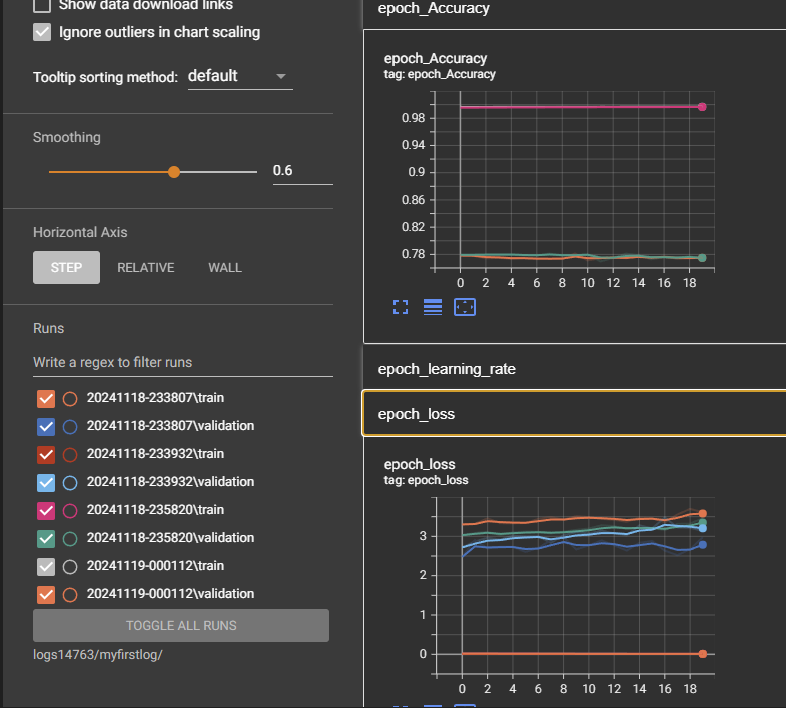

## **Q2**

In [ ]:
#Run in terminal

#  !pip install confluent_kafka google-api-python-client streamlit

In [ ]:
# Run in gitbash to begin:
wget https://raw.githubusercontent.com/confluentinc/cp-all-in-one/7.7.1-post/cp-all-in-one-kraft/docker-compose.yml
docker-compose up -d
docker-compose ps

# Run in gitbash to end:
docker-compose stop
docker system prune -a --volumes --filter "label=io.confluent.docker"

Code in youtube_producer.py and youtube_consumer.py file

Run youtube_producer.py:

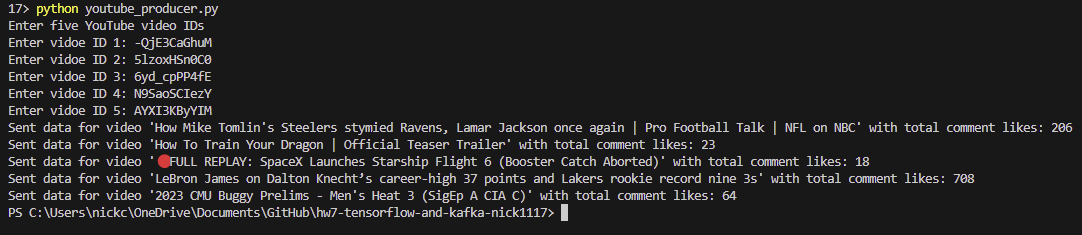

When run youtube_consumer.py:

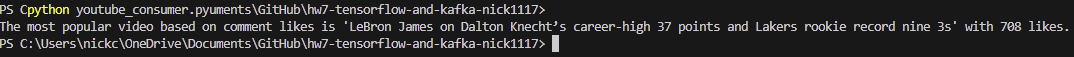

Screenshot of Kafka topic messages tab:

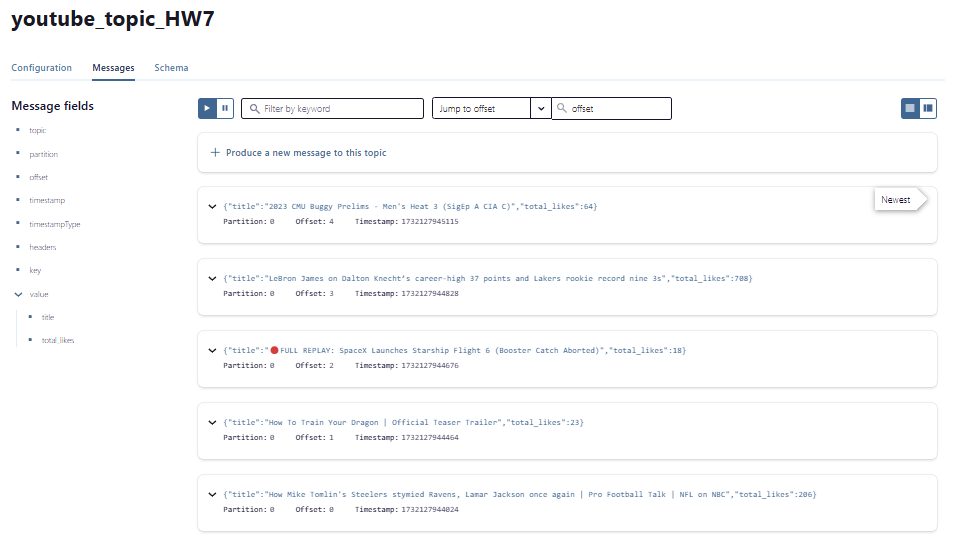